In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

import sys

from sklearn.tree import export_graphviz
from matplotlib import pyplot
# import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV   # cross validation(구버전)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro , normaltest , anderson , kstest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

#한글 폰트 적용# Big Data 분석(II) 종합실습
plt.rcParams["font.family"] = "NanumGothic"

## 1. 데이터 특성 확인 및 파생변수 생성

In [15]:
df = pd.read_csv('C:/Users/소은/Desktop/종합실습1/AIR_POLLUTION.csv', engine= 'python',encoding = 'euc-kr', parse_dates= ['MeasDate'])
df.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [16]:
path = 'C:/Program Files/Graphviz/bin/'

### 파생 변수 추가

### 바람을 8 방위로 나누었으며 날짜 데이터를 주중/주말, 계절로 나누었음

In [17]:
def separateDays(day):
    if day in [0,1,2,3,4]:
        return "주중"
    else:
        return "주말"
    
df['Weekday']=df['MeasDate'].dt.weekday
df['Weekday']=df['Weekday'].apply(separateDays)

In [18]:
def season(day):
    if day in [12, 1, 2]:
        return '겨울'
    elif day in [3,4,5]:
        return '봄'
    elif day in [6,7,8]:
        return '여름'
    elif day in [9,10,11]:
        return '가을'
    
df['Month']=df['MeasDate'].dt.month
df['Month']=df['Month'].apply(season)

In [19]:
def changeDir(dir):
    res = ''
    if dir <= 22:           res = "북"
    elif dir <= 67:         res = "북동"
    elif dir <= 112:        res = "동"
    elif dir <= 157:        res = "남동"
    elif dir <= 202:        res = "남"
    elif dir <= 247:        res = "남서"
    elif dir <= 292:        res = "서"
    elif dir <= 337:        res = "북서"
    else:                   res = "북"
    return res

In [20]:
df['WIND_DIRECTION_NAME'] = df['WIND_DIR'].apply(changeDir)

In [21]:
# 요약 통계량
df.describe()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,365.000000,365.000000,365.000000,311.000000,365.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,33.421918,0.023600,0.026814,0.517042,0.003033,13.863798,0.381639,2.225301,209.450820,60.295082,1005.848907,0.022951,5.064016
std,15.937983,0.011896,0.010271,0.152820,0.000632,9.830280,1.122127,0.723171,70.735018,14.534983,8.126823,0.222361,2.986119
min,5.000000,0.002000,0.008000,0.300000,0.002000,-7.950000,0.000000,0.940000,50.000000,17.900000,983.800000,0.000000,0.000000
25%,22.000000,0.014000,0.019000,0.400000,0.003000,5.492500,0.000000,1.722500,160.250000,49.650000,999.400000,0.000000,2.510000
50%,31.000000,0.023000,0.025000,0.500000,0.003000,14.000000,0.000000,2.095000,221.000000,61.050000,1006.450000,0.000000,5.310000
75%,42.000000,0.032000,0.034000,0.600000,0.003000,23.070000,0.115000,2.620000,266.000000,69.950000,1011.575000,0.000000,7.570000
max,101.000000,0.062000,0.059000,1.000000,0.005000,31.720000,11.800000,5.880000,351.000000,95.000000,1025.500000,3.200000,10.000000


### 결측치 확인

In [22]:
df.isnull().sum(axis=0)

MeasDate                0
PM10                    1
O3                      1
NO2                     1
CO                     55
SO2                     1
TEMP                    0
RAIN                    0
WIND                    0
WIND_DIR                0
HUMIDITY                0
ATM_PRESS               0
SNOW                    0
CLOUD                   0
Weekday                 0
Month                   0
WIND_DIRECTION_NAME     0
dtype: int64

In [23]:
df[df['PM10'].isnull()]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Weekday,Month,WIND_DIRECTION_NAME
328,2020-05-24,NaN,NaN,NaN,NaN,NaN,17.48,1.45,2.85,257,83.3,999.4,0.0,8.21,주말,봄,서


In [24]:
df.drop(df.index[328], inplace =True)

In [25]:
df.isnull().sum()

MeasDate                0
PM10                    0
O3                      0
NO2                     0
CO                     54
SO2                     0
TEMP                    0
RAIN                    0
WIND                    0
WIND_DIR                0
HUMIDITY                0
ATM_PRESS               0
SNOW                    0
CLOUD                   0
Weekday                 0
Month                   0
WIND_DIRECTION_NAME     0
dtype: int64

In [26]:
# 인덱스번호를 0 ~ 364번까지 초기화.
df.index = list(range(365))

### 결측치를 처리하기 위해 CO의 분포를 확인할 필요가 있다.

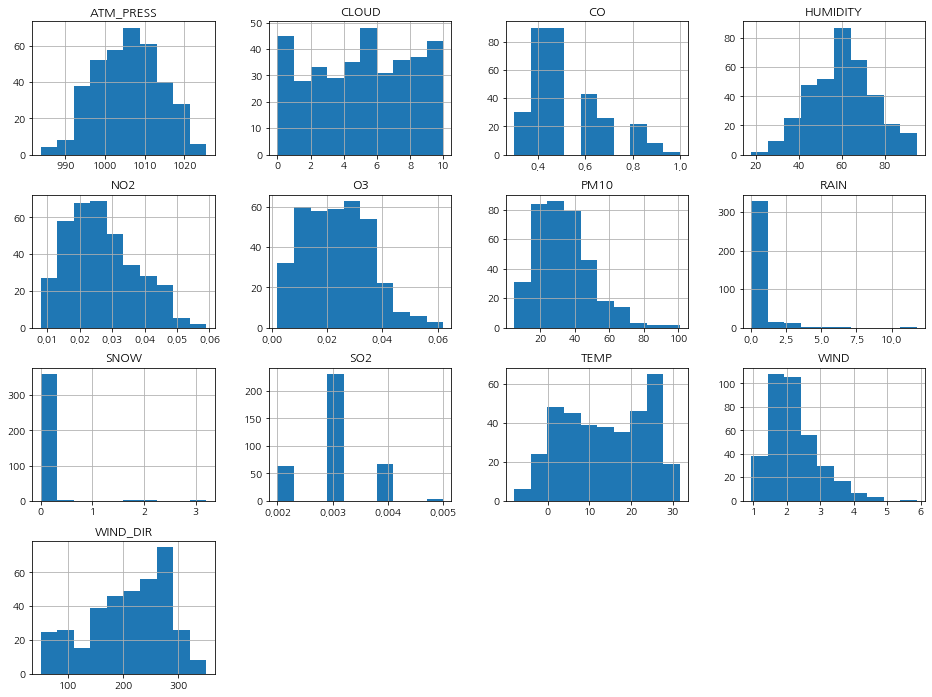

In [27]:
df.hist(figsize = (16, 12))
plt.show()

### 결측치를 가진 데이터 모두 그래프로 확인해본 결과 정규분포를 따르지 않으므로 평균이 아닌 최빈값으로 결측치를 대체하였다.

In [28]:
df['CO'].value_counts()

0.4    90
0.5    90
0.6    43
0.3    30
0.7    26
0.8    22
0.9     8
1.0     2
Name: CO, dtype: int64

In [29]:
# 최빈값 대체 
df['CO'].replace(to_replace = np.nan, value=0.4, inplace = True)

In [30]:
# 평균값 대체
# df.fillna(df.mean()['CO'], inplace=True)

In [31]:
df.isnull().sum(axis = 0)

MeasDate               0
PM10                   0
O3                     0
NO2                    0
CO                     0
SO2                    0
TEMP                   0
RAIN                   0
WIND                   0
WIND_DIR               0
HUMIDITY               0
ATM_PRESS              0
SNOW                   0
CLOUD                  0
Weekday                0
Month                  0
WIND_DIRECTION_NAME    0
dtype: int64

## 2. 그래프 분석 (산점도, 히트맵)

#### 산점도 분석을 한 결과 O3, TEMP, WIND, HUMIDITY가 미세먼지와 상관성이 약간 있는것으로 보인다.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


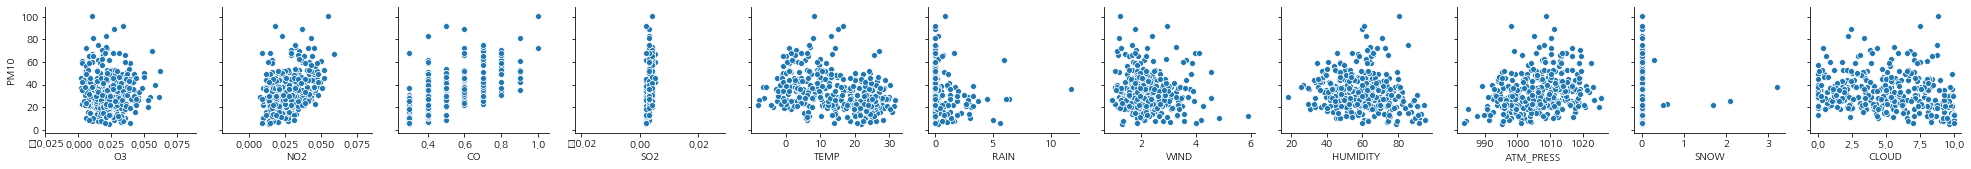

In [32]:
sns.pairplot(df,y_vars=['PM10'], x_vars = ['O3', 'NO2', 'CO', 'SO2','TEMP','RAIN','WIND','HUMIDITY', 'ATM_PRESS','SNOW','CLOUD'])

#### NO2, CO, SO2가 비교적 PM10과의 상관성이 높게 나옴

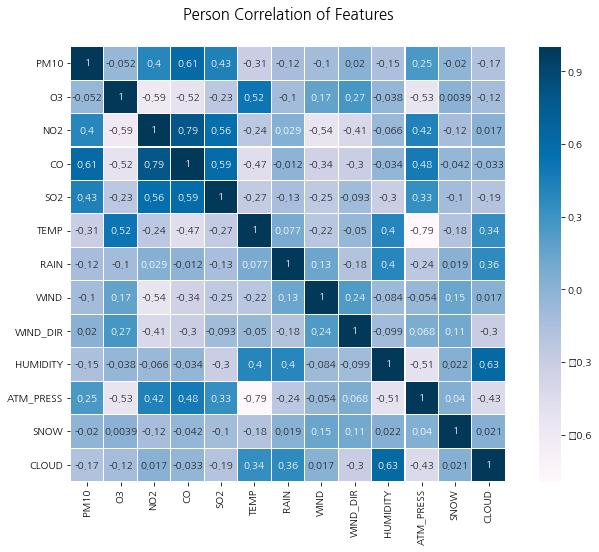

In [33]:
colormap = plt.cm.PuBu 
plt.figure(figsize=(12, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(df.corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = "white", annot = True)

#### 그러나 heatmap과 산점도는 선형적인 관계를 전제한다는 한계가 있음.
#### 실제로 계절이나 온도 등 대부분의 데이터들은 미세먼지와 비선형적인 관계를 가지고 있으므로 이를 파악하기 위해 t test와 아노바 등 통계적인 가설 검정을 진행할 예정임

## 3.통계적 가설검정 및 인자 선정

#### 파생변수로 생성한 weekday와 풍향의 분산분석 진행

In [34]:
df_dummy = pd.get_dummies(df)
df_dummy.head(300)

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,Month_봄,Month_여름,WIND_DIRECTION_NAME_남,WIND_DIRECTION_NAME_남동,WIND_DIRECTION_NAME_남서,WIND_DIRECTION_NAME_동,WIND_DIRECTION_NAME_북,WIND_DIRECTION_NAME_북동,WIND_DIRECTION_NAME_북서,WIND_DIRECTION_NAME_서
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,...,0,1,0,0,0,0,0,0,0,1
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,...,0,1,0,0,0,0,0,0,0,1
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,...,0,1,0,0,0,0,0,0,0,1
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,...,0,1,0,0,0,0,0,0,0,1
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2020-04-21,28.0,0.030,0.012,0.3,0.002,7.59,0.0,4.56,284,...,1,0,0,0,0,0,0,0,0,1
296,2020-04-22,68.0,0.026,0.009,0.3,0.002,6.04,0.0,4.13,300,...,1,0,0,0,0,0,0,0,1,0
297,2020-04-23,37.0,0.027,0.012,0.3,0.002,7.70,0.0,3.60,288,...,1,0,0,0,0,0,0,0,0,1
298,2020-04-24,34.0,0.030,0.020,0.4,0.003,9.56,0.0,3.91,241,...,1,0,0,0,1,0,0,0,0,0


#### 주말과 주중 사이에 유의미한 차이가 없으므로 미세먼지 양에 영향을 미치지 않는다고 유추할 수 있다.

In [35]:
# 2 sample t-test

In [36]:
Weekend = list() # 주말
Weekday = list() # 주중

for x in range(len(df_dummy)):
    if df_dummy['Weekday_주말'][x] == 1:
        Weekend.append(df_dummy['PM10'][x])

    elif df_dummy['Weekday_주중'][x] == 1:
        Weekday.append(df_dummy['PM10'][x])


df1 = pd.DataFrame({'sample' : Weekday }) # 주중
df2 = pd.DataFrame({'sample' : Weekend }) # 주말

In [37]:
# 정규성 검사
print(shapiro(df1))
print(shapiro(df2))
print()

# 등분산성 검사
print(stats.bartlett(df1['sample'], df2['sample']))
print()

t_result = stats.ttest_ind(df1,df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
print('2-sample t-test')
print(t, p)
print('t:{}'.format(t))
print('p:{}'.format(p))

(0.9372698664665222, 4.042686185812272e-09)
(0.9632505178451538, 0.005849048960953951)

BartlettResult(statistic=2.0485566163498534, pvalue=0.15235056620776838)

2-sample t-test
[-0.317] [0.751]
t:[-0.317]
p:[0.751]


### 파생변수로 생성한 바람의 방향에 따라 평균의 값이 유의미하게 차이가 나기 때문에 바람의 방향이 미세먼지 양에 영향을 미친다고 판단된다.

In [38]:
# 아노바 테스트

In [39]:
a = list()
b = list()
c = list()
d = list()
e = list()
f = list()
g = list()
h = list()


for x in range(len(df_dummy)):
    if df_dummy['WIND_DIRECTION_NAME_남'][x] == 1:
        a.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_남동'][x] == 1:
        b.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_남서'][x] == 1:
        c.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_동'][x] == 1:
        d.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_북'][x] == 1:
        e.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_북동'][x] == 1:
        f.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_북서'][x] == 1:
        g.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_서'][x] == 1:
        h.append(df_dummy['PM10'][x])
        
df_1 = pd.DataFrame({'sample' : a }) 
df_2 = pd.DataFrame({'sample' : b })
df_3 = pd.DataFrame({'sample' : c }) 
df_4 = pd.DataFrame({'sample' : d })
df_5 = pd.DataFrame({'sample' : e }) 
df_6 = pd.DataFrame({'sample' : f })
df_7 = pd.DataFrame({'sample' : g })
df_8 = pd.DataFrame({'sample' : h })

In [40]:
f_result = stats.f_oneway(df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8)
t, p = f_result.statistic.round(3), f_result.pvalue.round(3)
print(t, p)
print('one-way')
print('t:{}'.format(t))
print('p:{}'.format(p))

[2.487] [0.017]
one-way
t:[2.487]
p:[0.017]


### 파생변수로 생성한 계절에 따라 평균의 값이 유의미 하게 차이가 나기 때문에 계절 또한 미세먼지 양에 영향을 미친다.

In [41]:
spring = list()
summer = list()
fall = list()
winter = list()

for x in range(len(df_dummy)):
    if df_dummy['Month_봄'][x] == 1:
        spring.append(df_dummy['PM10'][x])

    elif df_dummy['Month_여름'][x] == 1:
        summer.append(df_dummy['PM10'][x])
        
    elif df_dummy['Month_가을'][x] == 1:
        fall.append(df_dummy['PM10'][x])
        
    elif df_dummy['Month_겨울'][x] == 1:
        winter.append(df_dummy['PM10'][x])


df1 = pd.DataFrame({'sample' : spring }) # 봄
df2 = pd.DataFrame({'sample' : summer }) # 여름
df3 = pd.DataFrame({'sample' : fall }) # 가을
df4 = pd.DataFrame({'sample' : winter }) # 겨울

In [42]:
a_result = stats.f_oneway(df1, df2, df3, df4)
t, p = a_result.statistic.round(3), a_result.pvalue.round(10)
print(t, p)
print('one-way')
print('t:{}'.format(t))
print('p:{}'.format(p))

[17.817] [1.e-10]
one-way
t:[17.817]
p:[1.e-10]


#### 의사결정 나무

In [43]:
df_dummy.drop(['MeasDate'], axis=1, inplace=True)

In [44]:
df_dummy.head(200)

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,...,Month_봄,Month_여름,WIND_DIRECTION_NAME_남,WIND_DIRECTION_NAME_남동,WIND_DIRECTION_NAME_남서,WIND_DIRECTION_NAME_동,WIND_DIRECTION_NAME_북,WIND_DIRECTION_NAME_북동,WIND_DIRECTION_NAME_북서,WIND_DIRECTION_NAME_서
0,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,...,0,1,0,0,0,0,0,0,0,1
1,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,...,0,1,0,0,0,0,0,0,0,1
2,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,...,0,1,0,0,0,0,0,0,0,1
3,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,...,0,1,0,0,0,0,0,0,0,1
4,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,46.0,0.025,0.018,0.6,0.004,-0.95,0.0,2.45,295,61.1,...,0,0,0,0,0,0,0,0,1,0
196,25.0,0.020,0.019,0.4,0.003,-2.65,0.0,2.36,308,52.8,...,0,0,0,0,0,0,0,0,1,0
197,30.0,0.013,0.031,0.6,0.003,-2.37,0.0,1.58,234,44.4,...,0,0,0,0,1,0,0,0,0,0
198,36.0,0.015,0.027,0.6,0.004,-2.71,0.0,1.89,266,44.6,...,0,0,0,0,0,0,0,0,0,1


In [45]:
df_dust_y = df_dummy['PM10']
df_dust_x = df_dummy.drop('PM10', axis = 1, inplace=False)

In [46]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_dust_x,df_dust_y,test_size=0.3)
print('train data X size:',df_train_x.shape)
print('train data Y size:',df_train_y.shape)
print('test data X size:',df_test_x.shape)
print('test data Y size:',df_test_y.shape)

train data X size: (255, 26)
train data Y size: (255,)
test data X size: (110, 26)
test data Y size: (110,)


In [47]:
tree_uncustomized = DTR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  1.0
test data 설명력:  -0.07116504140572277


In [48]:

v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.425
0,O3,0.084
4,TEMP,0.080
8,HUMIDITY,0.077
6,WIND,0.059
11,CLOUD,0.054
16,Month_봄,0.042
14,Month_가을,0.039
5,RAIN,0.037
9,ATM_PRESS,0.020


Text(0, 0.5, '변수')

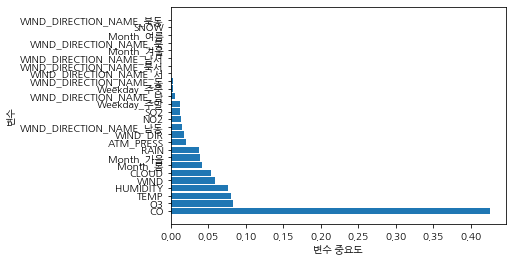

In [49]:
df_importance.sort_values('Importance', ascending=False, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

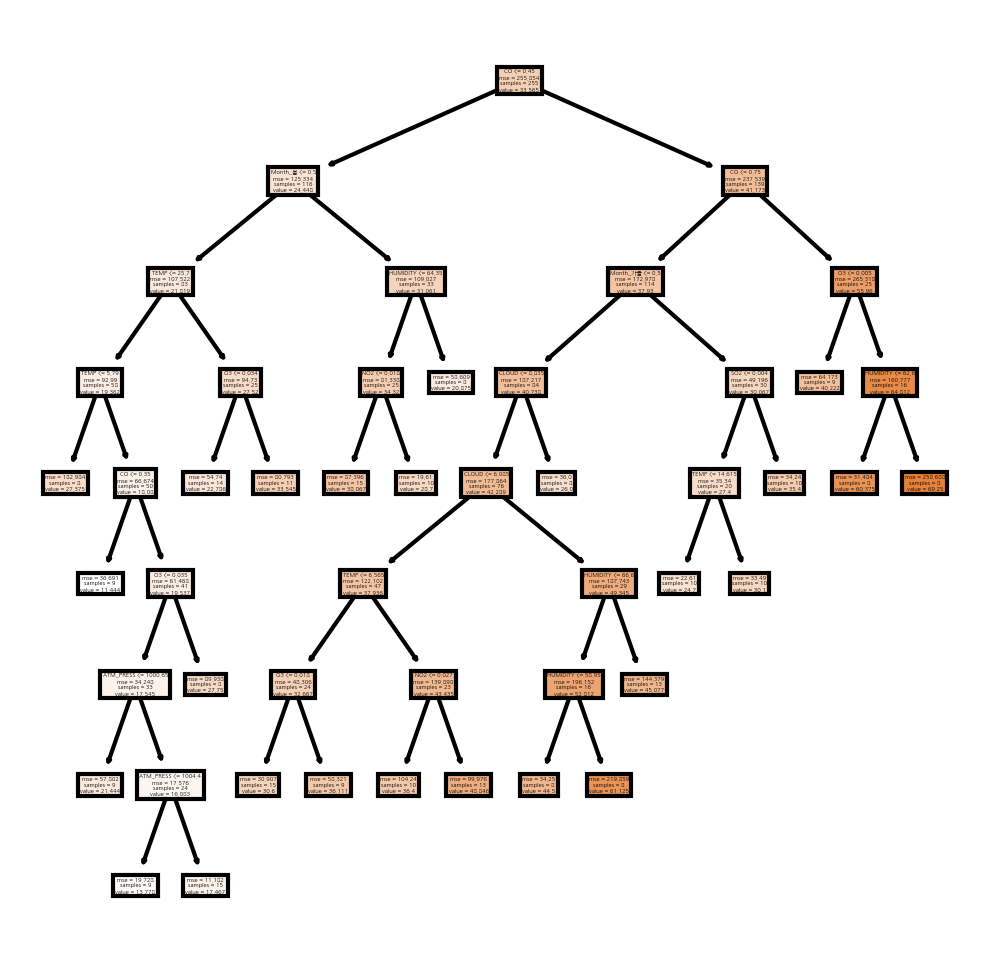

In [50]:
tree_graph = DTR( min_samples_leaf=8)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()

#### 랜덤 포레스트

In [51]:
tree_uncustomized = RFR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  0.9309656939664903
test data 설명력:  0.3618346842270598


In [52]:

v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.406
0,O3,0.098
6,WIND,0.075
7,WIND_DIR,0.054
16,Month_봄,0.054
8,HUMIDITY,0.046
11,CLOUD,0.045
4,TEMP,0.042
1,NO2,0.041
9,ATM_PRESS,0.031


Text(0, 0.5, '변수')

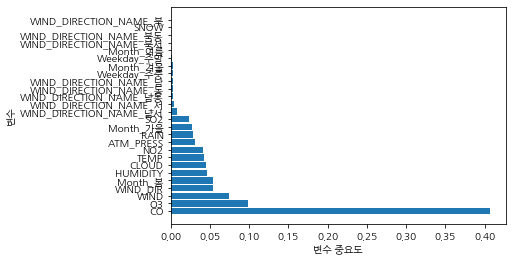

In [53]:
df_importance.sort_values('Importance', ascending=False, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### 그래디언트 부스팅

In [54]:
tree_uncustomized = GBR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  0.9559083865890277
test data 설명력:  0.37448968843386166


In [55]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.437
0,O3,0.115
16,Month_봄,0.064
8,HUMIDITY,0.057
14,Month_가을,0.047
11,CLOUD,0.047
6,WIND,0.046
4,TEMP,0.040
7,WIND_DIR,0.039
1,NO2,0.034


Text(0, 0.5, '변수')

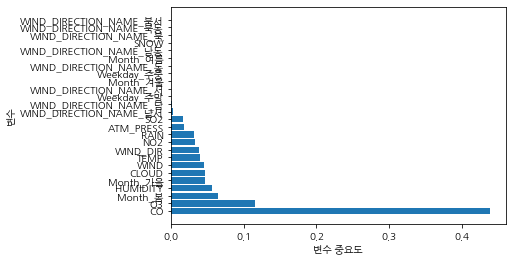

In [56]:
df_importance.sort_values('Importance', ascending=False, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### 위의 결과를 종합한 결과 O3, NO2, CO,TEMP, HUMIDITY, CLOUD, SEASON, WIND_DIRECTION_NAME를 주요 인자로 선정함.

## 4. 모델링 

### 다중회귀분석 
#### (이때 내가 생성한 파생변수인 season과 wind_direction은 범주형 데이터이기 때문에 가공전의 데이터를 넣었다.)

#### NO2, WIND, TEMP, HUMIDITY에서 약한 선형관계 확인

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


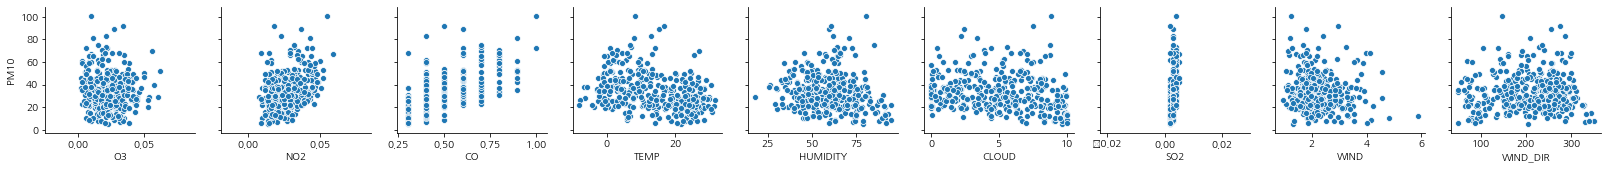

In [57]:
sns.pairplot(df, y_vars='PM10', x_vars=['O3','NO2','CO','TEMP','HUMIDITY','CLOUD', 'SO2','WIND', 'WIND_DIR'])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


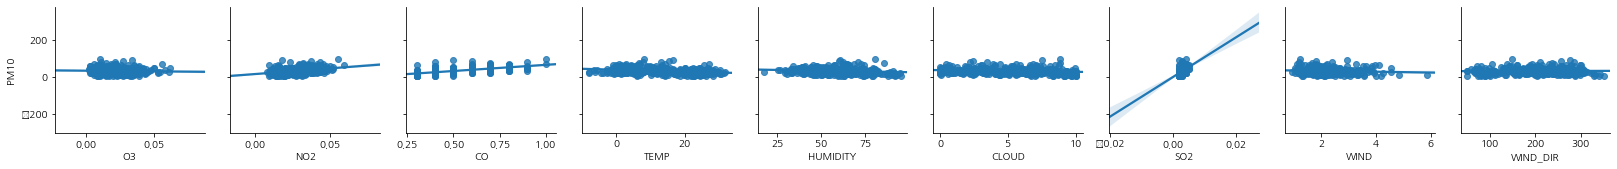

In [58]:
sns.pairplot(df, y_vars='PM10', x_vars=['O3','NO2','CO','TEMP','HUMIDITY','CLOUD', 'SO2','WIND','WIND_DIR'],kind='reg')

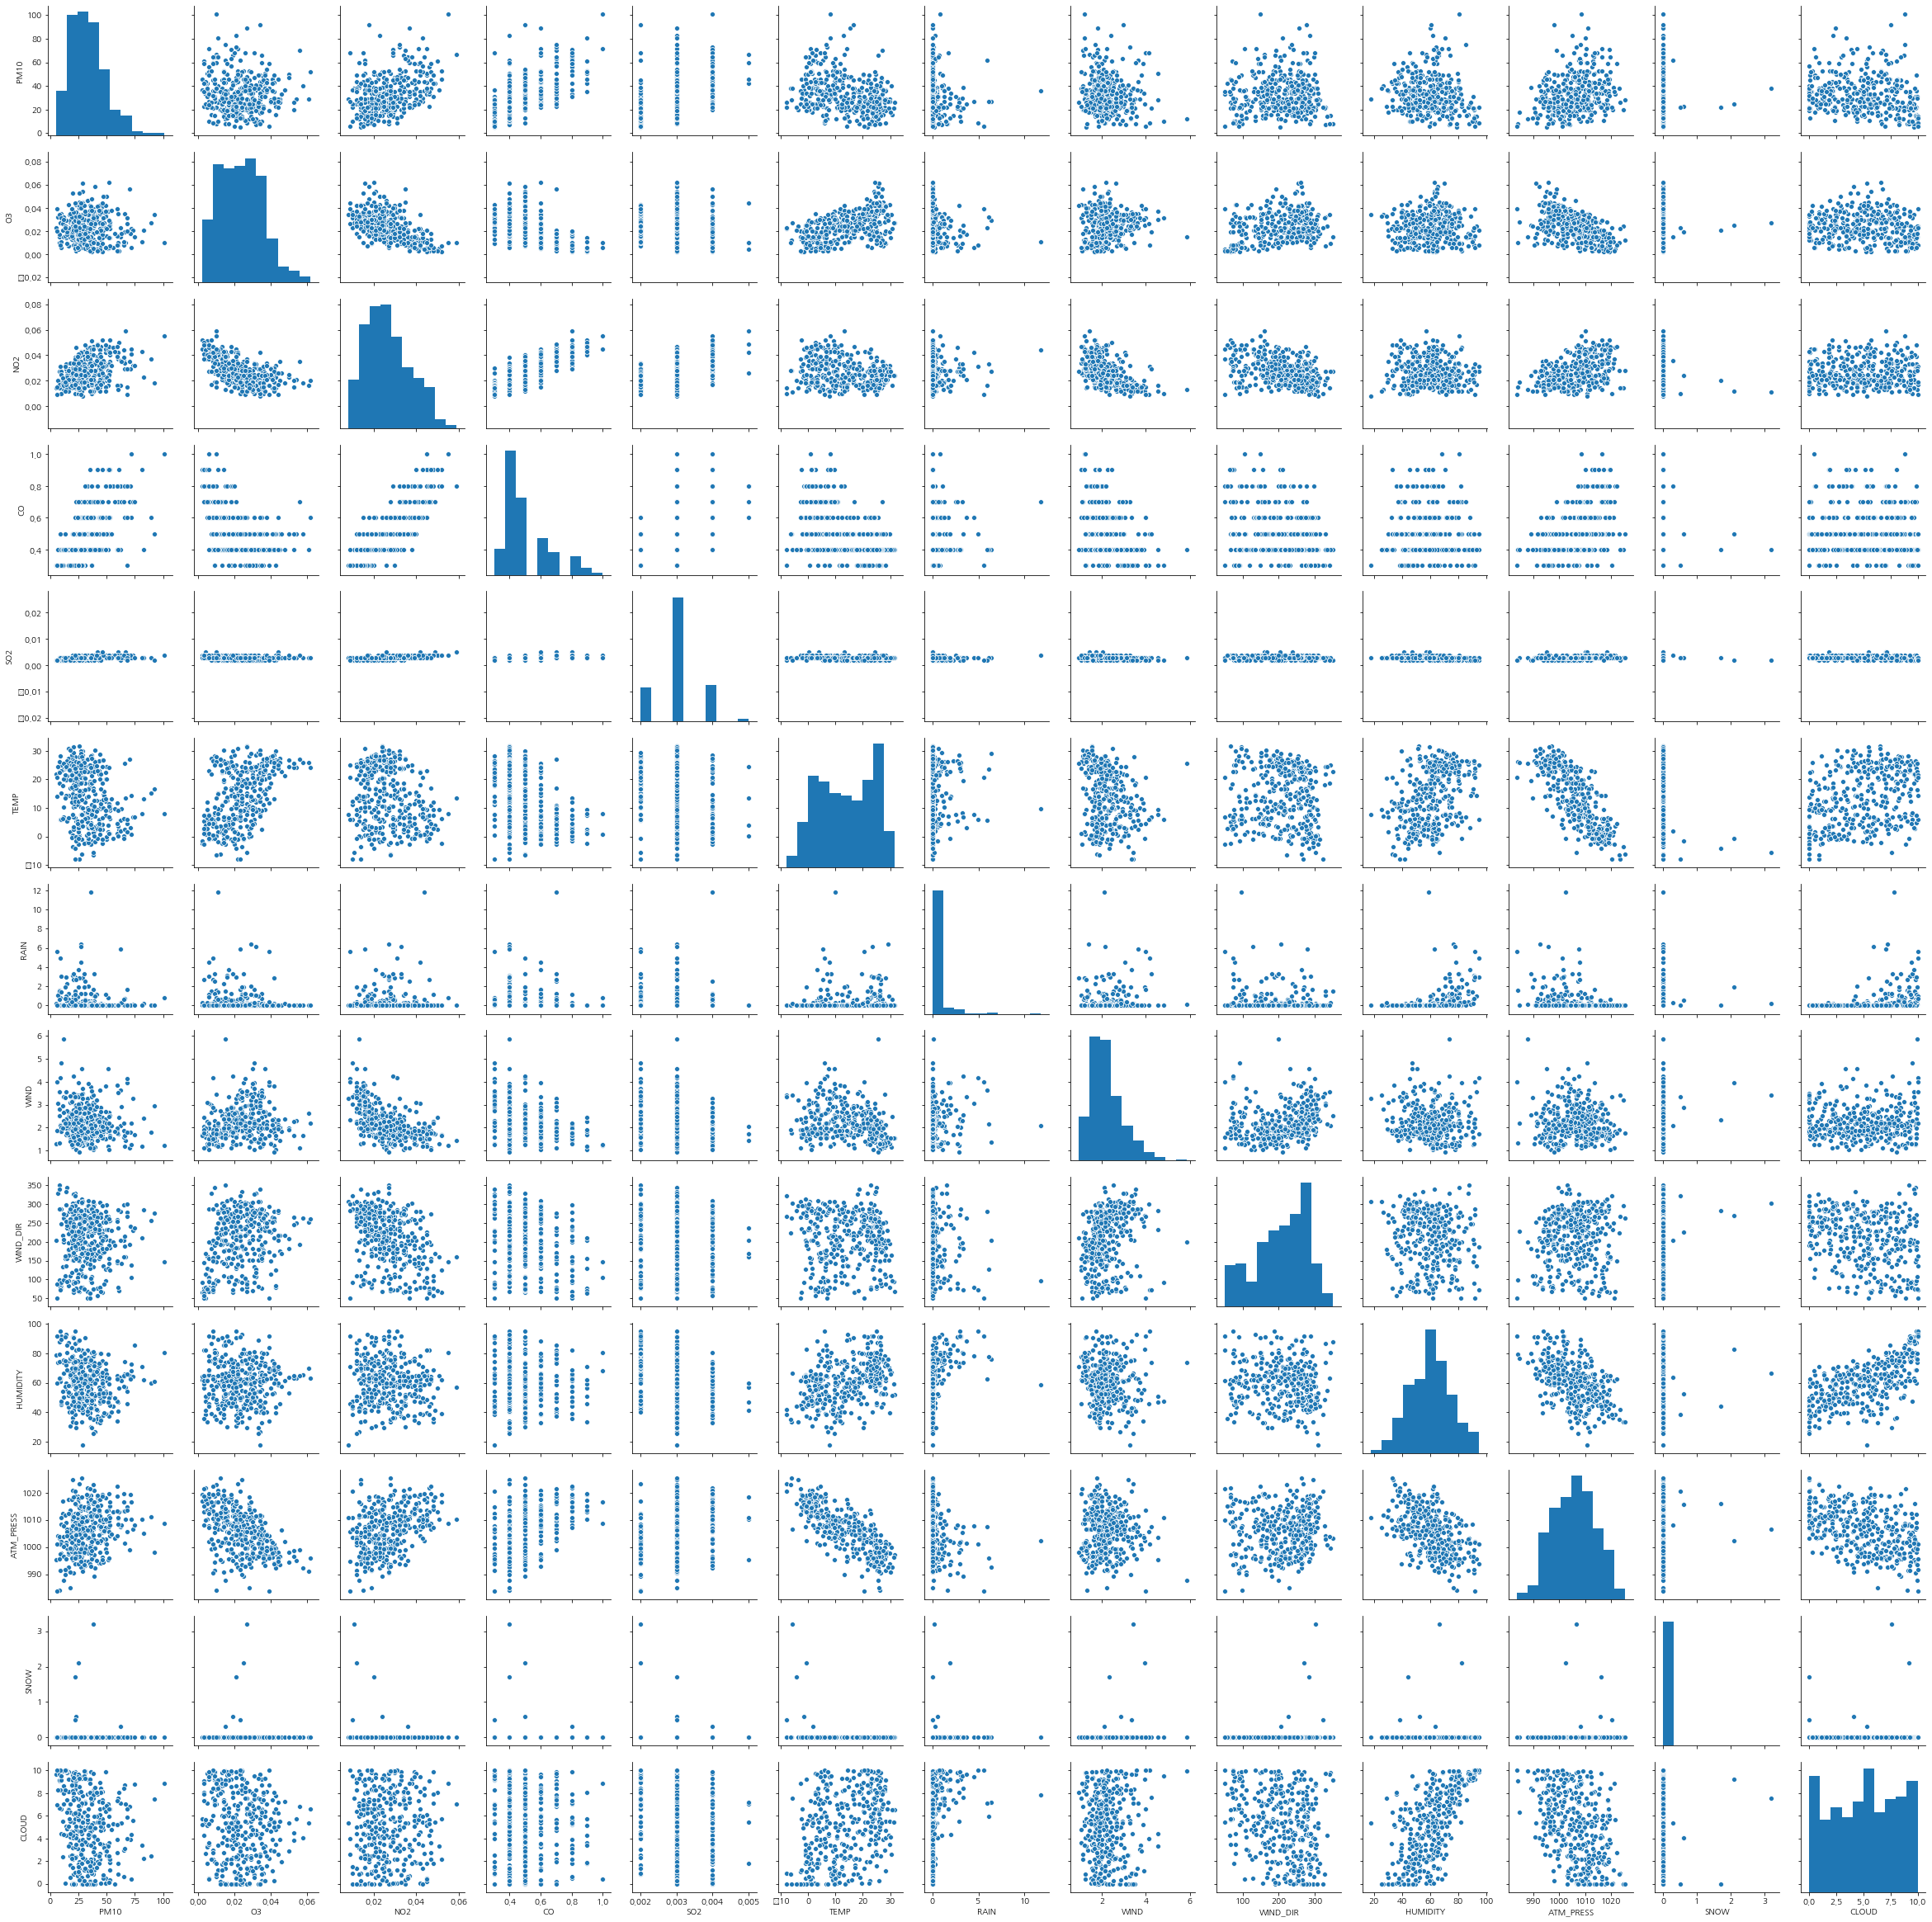

In [59]:
sns.pairplot(df)

In [60]:
df.corr().round(3)

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
PM10,1.000,-0.052,0.396,0.613,0.429,-0.310,-0.121,-0.100,0.020,-0.150,0.253,-0.020,-0.172
O3,-0.052,1.000,-0.592,-0.519,-0.234,0.516,-0.104,0.165,0.269,-0.038,-0.534,0.004,-0.119
NO2,0.396,-0.592,1.000,0.791,0.563,-0.237,0.029,-0.537,-0.408,-0.066,0.420,-0.121,0.017
CO,0.613,-0.519,0.791,1.000,0.594,-0.473,-0.012,-0.339,-0.302,-0.034,0.476,-0.042,-0.033
SO2,0.429,-0.234,0.563,0.594,1.000,-0.274,-0.129,-0.253,-0.093,-0.302,0.334,-0.103,-0.191
TEMP,-0.310,0.516,-0.237,-0.473,-0.274,1.000,0.077,-0.216,-0.050,0.404,-0.792,-0.185,0.342
RAIN,-0.121,-0.104,0.029,-0.012,-0.129,0.077,1.000,0.126,-0.183,0.397,-0.236,0.019,0.358
WIND,-0.100,0.165,-0.537,-0.339,-0.253,-0.216,0.126,1.000,0.235,-0.084,-0.054,0.146,0.017
WIND_DIR,0.020,0.269,-0.408,-0.302,-0.093,-0.050,-0.183,0.235,1.000,-0.099,0.068,0.108,-0.297
HUMIDITY,-0.150,-0.038,-0.066,-0.034,-0.302,0.404,0.397,-0.084,-0.099,1.000,-0.510,0.022,0.628


#### 다중선형 회귀분석 결과 O3,CO,WIND,WIND_DIR이 미세먼지 농도와 선형적인 관계를 가지고 있다는 것을 알게 됨.

In [61]:
reg_model = smf.ols(formula = '''PM10~ O3 + NO2 + CO + TEMP + HUMIDITY + CLOUD + SO2 + WIND + WIND_DIR''',data = df_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     43.10
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           8.25e-52
Time:                        14:05:18   Log-Likelihood:                -1393.2
No. Observations:                 365   AIC:                             2806.
Df Residuals:                     355   BIC:                             2845.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.1528      7.058     -4.839      0.0

In [62]:
# 다중 공선성을 위한 변수제거
mul_re = df.copy()
mul_re.drop(['MeasDate', 'PM10', 'WIND_DIRECTION_NAME', 'Month', 'Weekday'], axis=1, inplace=True)

In [63]:
# 모든 변수들의 다중 공선성(VIF)이 10미만이므로 재확인할 필요가 없다고 판단.

# 상수항 추가
df_x_const = add_constant(mul_re)

df_x_vif = pd.DataFrame()
df_x_vif['variable'] = df_x_const.columns
df_x_vif['VIF'] = [variance_inflation_factor(df_x_const.values, i)for i in range(df_x_const.shape[1])]

df_x_vif.sort_values("VIF", inplace = True)
df_x_vif.round(3)

,variable,VIF
11,SNOW,1.116
6,RAIN,1.370
8,WIND_DIR,1.510
7,WIND,1.925
4,SO2,1.967
12,CLOUD,2.087
9,HUMIDITY,2.707
1,O3,2.820
10,ATM_PRESS,4.646
3,CO,4.753


In [64]:
# 결론도출

scaler = StandardScaler()
cols = df_x_const.columns

np_scaled = scaler.fit_transform(df_x_const)
df_scaled = pd.DataFrame(np_scaled, columns = cols)

df_scaled["PM10"] = df['PM10']
reg_model_scaled = smf.ols(formula = "PM10~O3+ CO + WIND", data = df_scaled)
reg_result_scaled = reg_model_scaled.fit()
print(reg_result_scaled.summary())


                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     114.2
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           5.28e-52
Time:                        14:05:18   Log-Likelihood:                -1406.2
No. Observations:                 365   AIC:                             2820.
Df Residuals:                     361   BIC:                             2836.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.4219      0.600     55.697      0.0

### 미세먼지 발생량을 설명하는데에 있어 CO가 가장 큰 영향을 미치며 O3, WIND도 영향을 미침.

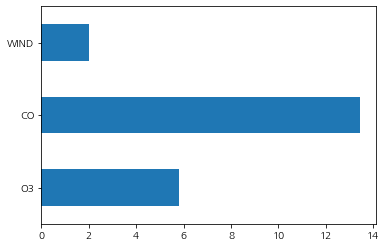

In [65]:
df_reg_coef = pd.DataFrame({"Coef":reg_result_scaled.params.values[1:]}, index = ['O3', 'CO', 'WIND'])
df_reg_coef.plot.barh(y = 'Coef', legend = False)

## 의사결정나무

In [66]:
df_y = df['PM10']
df_x = df.drop(['O3','NO2','CO','TEMP','HUMIDITY','CLOUD', 'SO2','WIND', 'WIND_DIR', 'Month'], axis = 1, inplace = True)


#### 의사결정 나무는 r제곱을 score의 default값으로 가지고 있으므로 변수들 간의 관계가 선형적이지 않은 경우 설명력이 음수가 나오기도 함.

In [67]:
tree_uncustomized = DTR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  1.0
test data 설명력:  -0.0839577053409708


In [68]:
# 잎사귀 노드의 최소 자료수 변경에 따른 모델 성능

train_score = [];test_score=[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree = DTR( min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

df_score_leaf = pd.DataFrame()

df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf["TestScore"] = test_score

In [69]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,-0.144
1,2,0.954,-0.139
2,3,0.873,0.028
3,4,0.829,0.013
4,5,0.794,0.082
5,6,0.765,0.111
6,7,0.740,0.036
7,8,0.720,0.230
8,9,0.684,0.214
9,10,0.659,0.204


#### train, test score를 모두 고려하여 잎사귀 노드의 최소 자료수를 2개로 선정

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


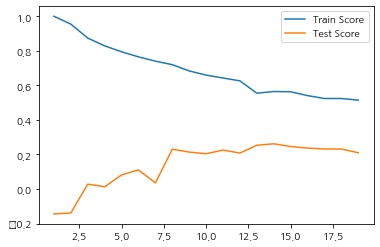

In [70]:
plt.plot(para_leaf, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = "-",label = 'Test Score')
plt.legend()

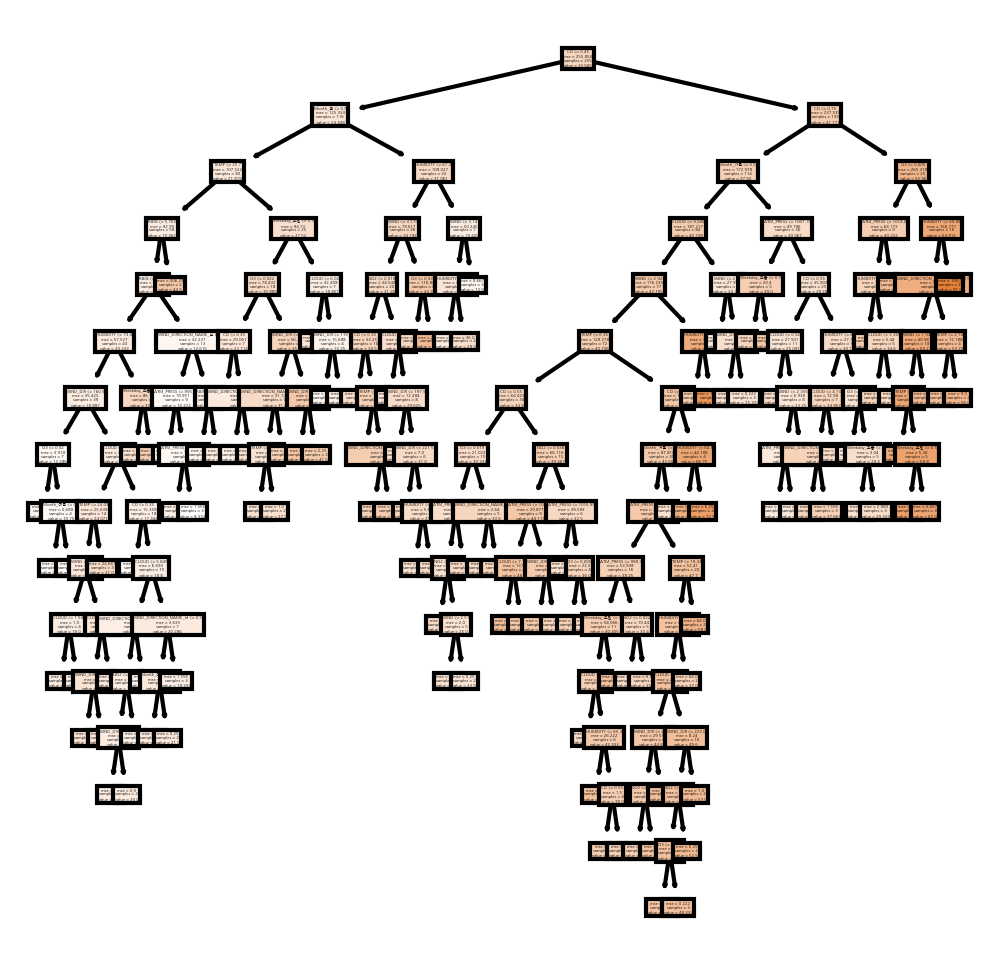

In [71]:
tree_graph = DTR(min_samples_leaf=2)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()

In [72]:
# 분리 노드의 최소 자료수
train_score = [];test_score=[]
para_split = [n_leaf * 2 for n_leaf in range(1,20)]

for v_min_samples_split in para_split:
    tree = DTR(min_samples_leaf=2, min_samples_split = v_min_samples_split)

    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.954,-0.219
1,4,0.955,-0.164
2,6,0.913,-0.064
3,8,0.880,-0.052
4,10,0.864,-0.015
5,12,0.843,0.012
6,14,0.841,0.035
7,16,0.820,0.076
8,18,0.792,0.076
9,20,0.777,0.055


#### train score와 test score의 정확도를 고려한 결과 분리노드의 최소 자료수는 14개로 선정

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


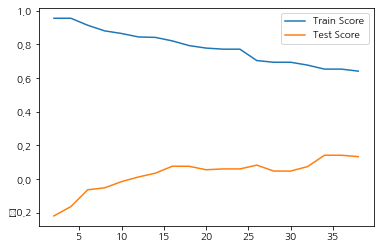

In [73]:
plt.plot(para_split, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_split, test_score, linestyle = "-",label = 'Test Score')
plt.legend()

In [74]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=DTR(max_depth = v_max_depth,min_samples_leaf = 2, min_samples_split = 23)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.271,0.183
1,2,0.404,0.277
2,3,0.532,0.135
3,4,0.611,0.124
4,5,0.659,0.076
5,6,0.697,0.037
6,7,0.745,0.071
7,8,0.759,0.052
8,9,0.771,0.060
9,10,0.771,0.060


#### train score와 test score를 고려했을때 깊이를 6으로 선정

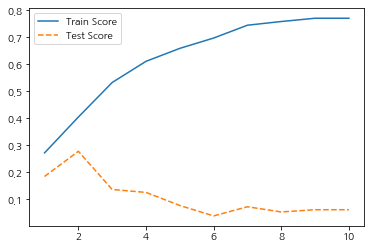

In [75]:
plt.plot(para_depth, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = "--",label = 'Test Score')
plt.legend()

 ### 최종 의사결정 나무 선정

In [76]:
dt_final = DTR(min_samples_leaf=2, min_samples_split=24, max_depth = 6)
dt_final.fit(df_train_x,df_train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=24,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

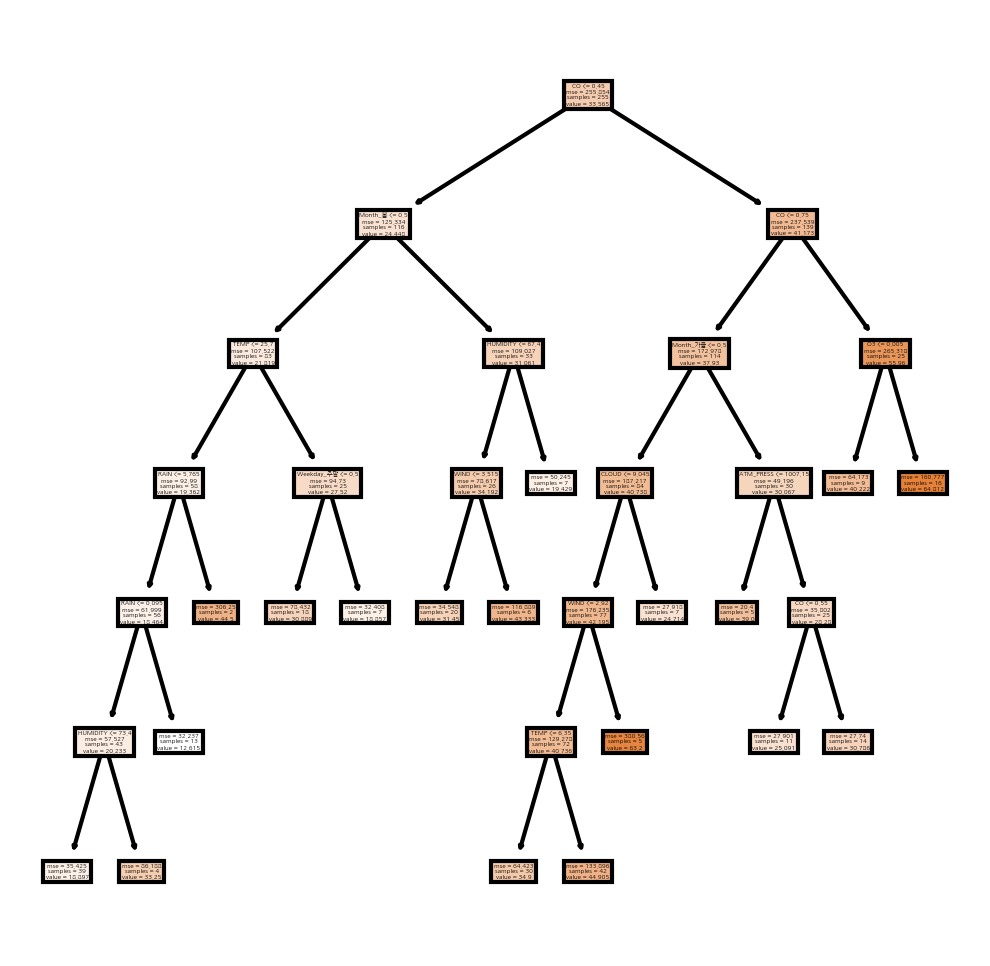

In [77]:
tree_graph = DTR(min_samples_leaf=2, min_samples_split=24, max_depth = 6)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()

In [78]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = dt_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.540
0,O3,0.077
6,WIND,0.066
4,TEMP,0.064
14,Month_가을,0.055
16,Month_봄,0.044
11,CLOUD,0.043
8,HUMIDITY,0.043
5,RAIN,0.041
12,Weekday_주말,0.016


Text(0, 0.5, '변수')

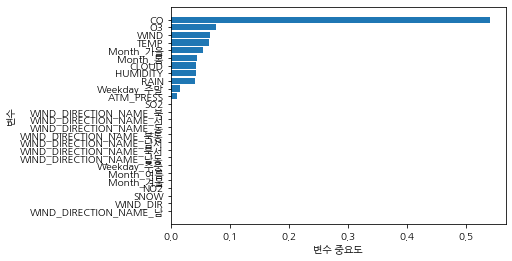

In [79]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

### 파라미더 값을 지정하기전 설명력은 음수였으나 파라미터 값을 수정한 후에는 설명력이 32%로 상승했다.

In [80]:
print('train data 설명력: ', dt_final.score(df_train_x,df_train_y))
print('test data 설명력: ', dt_final.score(df_test_x,df_test_y))

train data 설명력:  0.697401219528053
test data 설명력:  0.037109617330860156


## 랜덤 포레스트

In [81]:
tree_uncustomized = RFR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  0.9292461769884313
test data 설명력:  0.34527945520896686


In [82]:
# 잎사귀 노드의 최소 자료수 변경에 따른 모델 성능

train_score = [];test_score=[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    rf = RFR( min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

df_score_leaf = pd.DataFrame()

df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf["TestScore"] = test_score

In [83]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.939,0.348
1,2,0.899,0.358
2,3,0.859,0.384
3,4,0.828,0.362
4,5,0.790,0.382
5,6,0.764,0.387
6,7,0.744,0.386
7,8,0.719,0.386
8,9,0.691,0.377
9,10,0.664,0.383


#### train, test score를 모두 고려하여 잎사귀 노드의 최소 자료수를 4개로 선정

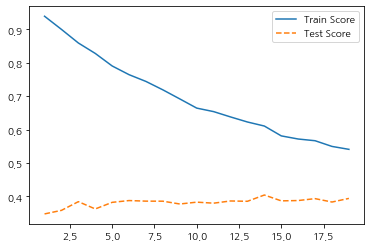

In [84]:
plt.plot(para_leaf, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = "--",label = 'Test Score')
plt.legend()

AttributeError: 'RandomForestRegressor' object has no attribute 'tree_'

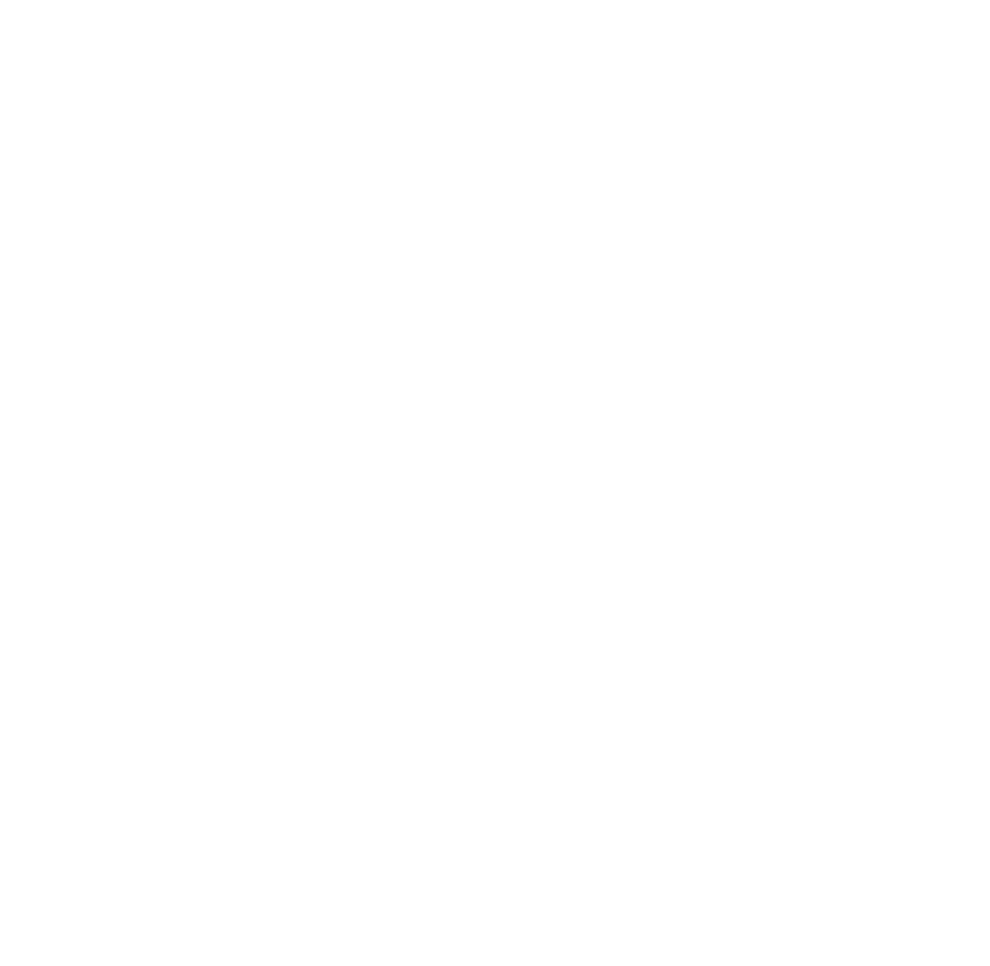

In [85]:
tree_graph = RFR(min_samples_leaf=4)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()

In [ ]:
# 분리 노드의 최소 자료수
train_score = [];test_score=[]
para_split = [n_leaf * 2 for n_leaf in range(1,20)]

for v_min_samples_split in para_split:
    tree = RFR(min_samples_leaf=4, min_samples_split = v_min_samples_split)

    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

#### train, test score를 확인한 결과 분리 노드의 최소 자료수는 7개로 선정

In [ ]:
plt.plot(para_split, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_split, test_score, linestyle = "-",label = 'Test Score')
plt.legend()

In [ ]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=RFR(max_depth = v_max_depth,min_samples_leaf = 4, min_samples_split = 7)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

#### train, test score를 확인한 결과 깊이는 6으로 지정

In [ ]:
plt.plot(para_depth, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = "--",label = 'Test Score')
plt.legend()

### 최종 랜덤 포레스트 생성

In [ ]:
rf_final = RFR(min_samples_leaf=4, min_samples_split=7, max_depth = 6)
rf_final.fit(df_train_x,df_train_y)

In [ ]:
tree_graph = RFR(min_samples_leaf=4, min_samples_split=7, max_depth = 6)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()

In [ ]:
df_importance= pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

In [ ]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [ ]:
print('train data 설명력: ', rf_final.score(df_train_x,df_train_y))
print('test data 설명력: ', rf_final.score(df_test_x,df_test_y))

### 그래디언트 부스팅

In [ ]:
tree_uncustomized = GBR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

In [ ]:
# 잎사귀 노드의 최소 자료수 변경에 따른 모델 성능

train_score = [];test_score=[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    rf = GBR( min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

df_score_leaf = pd.DataFrame()

df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf["TestScore"] = test_score

In [ ]:
df_score_leaf.round(3)

#### train, test score를 모두 고려하여 잎사귀 노드의 최소 자료수를 4개로 선정

In [ ]:
plt.plot(para_leaf, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = "--",label = 'Test Score')
plt.legend()

In [ ]:
tree_graph = GBR(min_samples_leaf=4)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()

In [ ]:
# 분리 노드의 최소 자료수
train_score = [];test_score=[]
para_split = [n_leaf * 2 for n_leaf in range(1,20)]

for v_min_samples_split in para_split:
    tree = GBR(min_samples_leaf=4, min_samples_split = v_min_samples_split)

    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

#### train, test score를 확인한 결과 분리 노드의 최소 자료수는 13개로 선정

In [ ]:
plt.plot(para_split, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_split, test_score, linestyle = "-",label = 'Test Score')
plt.legend()

In [ ]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=GBR(max_depth = v_max_depth,min_samples_leaf = 4, min_samples_split = 7)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

#### train, test score를 확인한 결과 깊이는 3으로 지정

In [ ]:
plt.plot(para_depth, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = "--",label = 'Test Score')
plt.legend()

In [ ]:
gb_final = GBR(min_samples_leaf=4, min_samples_split=13, max_depth = 3)
gb_final.fit(df_train_x,df_train_y)

In [ ]:
tree_graph = RFR(min_samples_leaf=4, min_samples_split=7, max_depth = 6)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()

In [ ]:
df_importance= pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

In [ ]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [ ]:
print('train data 설명력: ', gb_final.score(df_train_x,df_train_y))
print('test data 설명력: ', gb_final.score(df_test_x,df_test_y))

## 모델 평가

In [ ]:
# 평가 함수 정의

def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true -y_pred)/y_true))*100

In [ ]:
models = ['회귀분석', '의사결정나무', '랜덤 포레스트', '그래디언트 부스팅']
mse, rmse, mae, mape = [], [], [], []

In [ ]:
#회귀분석 예측
lr_y_pred = reg_result_scaled.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,lr_y_pred))
rmse.append(root_mean_squared_error(df_test_y,lr_y_pred))
mae.append(mean_absolute_error(df_test_y,lr_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,lr_y_pred))

In [ ]:
# 의사결정 나무 예측
dt_y_pred = dt_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y,dt_y_pred))
mae.append(mean_absolute_error(df_test_y,dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,dt_y_pred))

In [ ]:
# 랜덤 포레스트 예측
rf_y_pred = rf_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y,rf_y_pred))
mae.append(mean_absolute_error(df_test_y,rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,rf_y_pred))

In [ ]:
# 그래디언트 부스팅 예측
gb_y_pred = gb_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y,gb_y_pred))
mae.append(mean_absolute_error(df_test_y,gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,gb_y_pred))

In [ ]:
# 평가

fig, ax = plt.subplots(2,2, figsize = (13,10))
print(models, mse)

ax[0,0].bar(models, mse)
ax[0,0].set_title('mse').set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title('rmse').set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title('mae').set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title('mape').set_fontsize(15)
plt.show()